In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/VOCtrainval_11-May-2012.tar"


/content/drive/MyDrive/VOCtrainval_11-May-2012.tar


In [ ]:
import tarfile
import os

tar_path = '/content/drive/MyDrive/VOCtrainval_11-May-2012.tar'
extract_path = '/content/VOCtrainval_11-May-2012'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_path)

print('Extraction done!')


Extraction done!


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
root_dir = '/content/VOCtrainval_11-May-2012/VOCdevkit/VOC2012'

## **Data Set Class**

In [ ]:
class VOCDataset(Dataset):
    def __init__(self, root_dir, image_set, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        image_set_path = os.path.join(root_dir, 'ImageSets', 'Segmentation', f'{image_set}.txt')
        with open(image_set_path, 'r') as file:
            self.file_names = [line.strip() for line in file]

        self.images = [os.path.join(root_dir, 'JPEGImages', f'{name}.jpg') for name in self.file_names]
        self.masks = [os.path.join(root_dir, 'SegmentationClass', f'{name}.png') for name in self.file_names]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = Image.open(self.images[idx]).convert('RGB')
      mask = Image.open(self.masks[idx])
      if self.transform:
          augmented = self.transform(image=np.array(image), mask=np.array(mask))
          image = augmented['image']
          mask = augmented['mask']

          mask = torch.as_tensor(mask, dtype=torch.long).squeeze(0)

          mask = torch.clamp(mask, 0, 20)
      return image, mask

# **Transforms**

In [ ]:
def get_training_transforms():
        return A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomRotate90(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})

def get_testing_transforms():
        return A.Compose([
            A.Resize(512, 512),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

# **Data Loader**

In [ ]:
train_dataset = VOCDataset(root_dir, image_set='train', transform=get_training_transforms())
test_dataset = VOCDataset(root_dir, image_set='val', transform=get_testing_transforms())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

num_train_examples = len(train_dataset)
num_test_examples = len(test_dataset)
print("Number of training examples:", num_train_examples)
print("Number of testing examples:", num_test_examples)

Number of training examples: 1464
Number of testing examples: 1449


In [ ]:
def check_data_loader(loader):
    for images, masks in loader:
        print("Images shape:", images.shape)
        print("Masks shape:", masks.shape)
        print("Unique labels in masks:", masks.unique())
        break
check_data_loader(train_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 512, 512])
Unique labels in masks: tensor([ 0,  3, 15, 16, 19, 20])


# **Data Visualization**

In [ ]:
def show_images_from_dataloader(dataloader, num_images=4):
    fig, axes = plt.subplots(ncols=num_images, figsize=(num_images * 4, 4))
    dataiter = iter(dataloader)
    images, masks = next(dataiter)

    for i in range(num_images):
        ax = axes[i]
        img = transforms.Resize((224, 224))(images[i])
        img = img.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


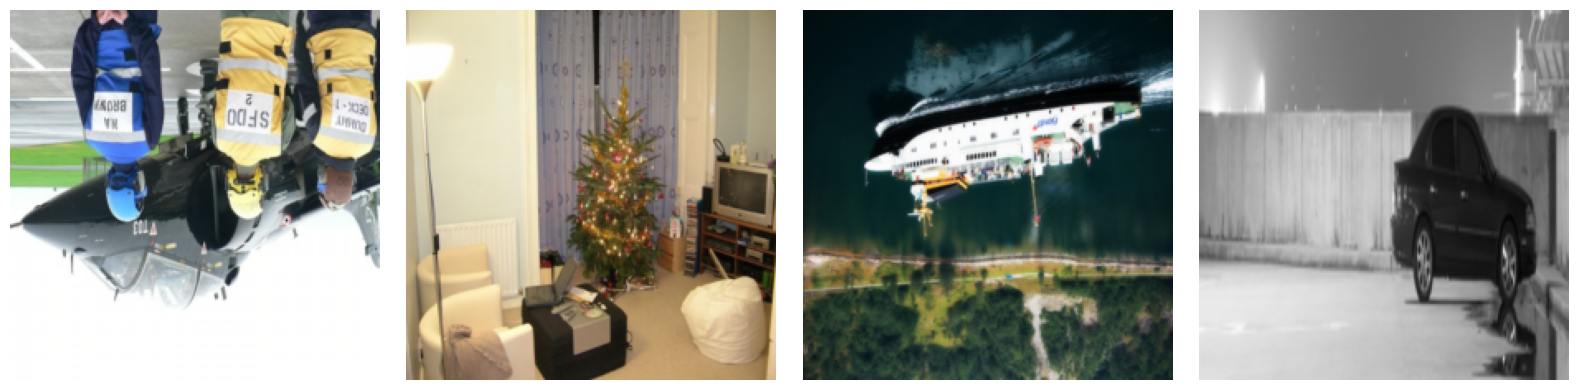

In [ ]:
show_images_from_dataloader(train_loader, num_images=4)


# **Model Architecture**

In [ ]:
class Encoder_Block(torch.nn.Module):
    def __init__(self, inp_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.pooling = torch.nn.MaxPool2d(2)
    def forward(self, x):
        int_out = self.model(x)
        return self.pooling(int_out), int_out


In [ ]:
class Decoder_Block(torch.nn.Module):
    def __init__(self, inp_channels, out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels, out_channels, kernel_size=2, stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self, x, enc_x):
        x = self.upsample(x)
        x = torch.cat([x, enc_x], dim=1)
        return self.model(x)

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self, inc, outc, hidden_size=64):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc, hidden_size),
            Encoder_Block(hidden_size, hidden_size*2),
            Encoder_Block(hidden_size*2, hidden_size*4),
            Encoder_Block(hidden_size*4, hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8, hidden_size*16, kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16, hidden_size*16, kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16, hidden_size*8),
            Decoder_Block(hidden_size*8, hidden_size*4),
            Decoder_Block(hidden_size*4, hidden_size*2),
            Decoder_Block(hidden_size*2, hidden_size),
        ])
        self.last_layer = torch.nn.Conv2d(hidden_size, outc, kernel_size=3, padding="same")

    def forward(self, x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x = module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i, module in enumerate(self.Decoder):
            x = module(x, enc_xs[i])
        return self.last_layer(x)

In [ ]:
unet = Unet(3 ,21)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
unet.to(device)

In [ ]:
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# **Optimizer, loss function and scheduler**

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

# **IOU AND DICE Calculation**

In [ ]:
def calculate_iou_multiclass(preds, labels, num_classes=21):
    smooth = 1e-6
    iou_per_class = []
    if preds.dim() > 3:
        preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        cls_mask = cls * torch.ones_like(preds)
        true_positive = (preds == cls_mask) & (labels == cls_mask)
        false_positive = (preds == cls_mask) & (labels != cls_mask)
        false_negative = (preds != cls_mask) & (labels == cls_mask)
        intersection = true_positive.sum()
        union = intersection + false_positive.sum() + false_negative.sum()
        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)
    mean_iou = torch.stack(iou_per_class).nanmean().item()
    return mean_iou

def calculate_dice_multiclass(preds, labels, num_classes=21):
    smooth = 1e-6
    dice_per_class = []
    if preds.dim() > 3:
        preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        cls_mask = cls * torch.ones_like(preds)
        true_positive = (preds == cls_mask) & (labels == cls_mask)
        false_positive = (preds == cls_mask) & (labels != cls_mask)
        false_negative = (preds != cls_mask) & (labels == cls_mask)
        intersection = true_positive.sum()
        dice = (2. * intersection + smooth) / (true_positive.sum() + false_positive.sum() + false_negative.sum() + smooth)
        dice_per_class.append(dice)
    return torch.stack(dice_per_class).nanmean().item()


# **Training Function**

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}')

# **Validation Function**

In [ ]:
def validate_model(model, dataloader, criterion, device, num_classes=21, num_samples=4):
    model.eval()
    best_results = []
    worst_results = []
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    count_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks).item()
            preds = torch.argmax(outputs, dim=1)


            batch_iou = calculate_iou_multiclass(preds, masks, num_classes)
            batch_dice = calculate_dice_multiclass(preds, masks, num_classes)
            total_iou += batch_iou
            total_dice += batch_dice


            total_loss += loss
            count_batches += 1

            result = (loss, images.cpu(), masks.cpu(), preds.cpu())

            if len(best_results) < num_samples:
                best_results.append(result)
                best_results.sort(key=lambda x: x[0])
            elif loss < best_results[-1][0]:
                best_results[-1] = result
                best_results.sort(key=lambda x: x[0])

            if len(worst_results) < num_samples:
                worst_results.append(result)
                worst_results.sort(key=lambda x: x[0], reverse=True)
            elif loss > worst_results[-1][0]:
                worst_results[-1] = result
                worst_results.sort(key=lambda x: x[0], reverse=True)

    avg_loss = total_loss / count_batches
    avg_iou = total_iou / count_batches
    avg_dice = total_dice / count_batches

    return avg_loss, avg_iou, avg_dice, best_results, worst_results


# **Function for best and worst segmentation results**

In [ ]:
def display_segmentation_results(results, title):
    fig, axes = plt.subplots(len(results), 3, figsize=(12, len(results) * 4))
    for i, (loss, images, true_masks, pred_masks) in enumerate(results):
        for j, (image, true_mask, pred_mask) in enumerate(zip(images, true_masks, pred_masks)):
            if j == 0:
                axes[i, 0].imshow(image.numpy().transpose((1, 2, 0)) * std + mean)
                axes[i, 0].set_title('Original Image')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(true_mask.numpy(), cmap='jet')
                axes[i, 1].set_title('True Mask')
                axes[i, 1].axis('off')

                axes[i, 2].imshow(pred_mask.numpy(), cmap='jet')
                axes[i, 2].set_title('Predicted Mask')
                axes[i, 2].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# **Main Training loop**

In [ ]:
epochs = 15
best_loss = float('inf')

for epoch in range(epochs):
    print(f'Starting epoch {epoch + 1}/{epochs}')
    train_model(unet, train_loader, optimizer, criterion, device, 1)
    avg_loss, avg_iou, avg_dice, best_results, worst_results = validate_model(unet, test_loader, criterion, device, num_classes=21, num_samples=4)

    print(f'Epoch {epoch + 1}: Avg Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}')

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(unet.state_dict(), './best_model.pth')
        print(f"New best model saved with loss {best_loss}")

    if epoch == epochs - 1:
        display_segmentation_results(best_results, 'Final Best Results')
        display_segmentation_results(worst_results, 'Final Worst Results')


# **Inference**

In [ ]:
def inference(model_path, image_path, mask_path, device):
    model = Unet(3, 21)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path)
    transformed = transform(image=np.array(image), mask=np.array(mask))
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    mask_tensor = torch.as_tensor(transformed['mask'], dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_mask = torch.argmax(output, dim=1)

    iou_score = calculate_iou_multiclass(predicted_mask, mask_tensor, num_classes=21)
    dice_score = calculate_dice_multiclass(predicted_mask, mask_tensor, num_classes=21)

    print(f"IoU Score: {iou_score:.4f}")
    print(f"Dice Score: {dice_score:.4f}")

    return iou_score, dice_score

# **Inference on an example from dataset**

In [ ]:
model_path = '/content/best_model.pth'
image_path1 = '/content/2007_000033.jpg'
mask_path1 = '/content/2007_000033.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference(model_path, image_path1, mask_path1, device)

IoU Score: 0.8946
Dice Score: 0.9320


(0.8945921063423157, 0.932041347026825)

# **Drawing inferences on data that lie beyond the confines of the dataset**

In [ ]:
image_path2 = '/content/000001_001.jpg'
mask_path2 = '/content/000001_001.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference(model_path, image_path2, mask_path2, device)

IoU Score: 0.6230
Dice Score: 0.6270


(0.6230381727218628, 0.6270287036895752)

In [ ]:
image_path3 = '/content/000001_094.jpg'
mask_path3 = '/content/000001_094.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference(model_path, image_path3, mask_path3, device)

IoU Score: 0.5781
Dice Score: 0.5848


(0.5781106352806091, 0.5847927331924438)

In [ ]:
image_path4 = '/content/000001_123.jpg'
mask_path4 = '/content/000001_123.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference(model_path, image_path4, mask_path4, device)

IoU Score: 0.6245
Dice Score: 0.6299


(0.6244708299636841, 0.6298940777778625)

# **Report**


#Introduction
Semantic segmentation is a crucial task in computer vision that involves labeling each pixel in an image with a corresponding class label. This report documents the implementation of a semantic segmentation model using the UNet architecture trained on the Pascal VOC 2012 dataset. The goal is to accurately segment objects within images.

# Objective
The primary objective of this assignment is to develop a semantic segmentation model capable of accurately identifying and delineating objects within images. This involves training the model on a dataset of labeled images and evaluating its performance based on metrics such as loss, Intersection over Union (IoU), and Dice similarity coefficient.

# Implementation Details
The project utilized the PyTorch framework and was implemented in a Jupyter Notebook environment. The key components of the implementation include:

1. **Data Preparation**: The Pascal VOC 2012 dataset was used for training and evaluation. This dataset consists of images with corresponding segmentation masks for various object classes.

2. **Model Architecture**: The model architecture employed is based on the UNet architecture, which consists of an encoder-decoder structure with skip connections. The encoder extracts features from the input image, while the decoder upsamples these features to generate the final segmentation mask.

3. **Training and Validation**: The model was trained using the Adam optimizer with a learning rate scheduler. Training was performed over multiple epochs, with validation conducted after each epoch to assess the model's performance.

4. **Evaluation Metrics**: The model's performance was evaluated using metrics such as loss, IoU, and Dice score. These metrics provide insights into the model's accuracy and segmentation quality.

5. **Inference**: Inference was conducted on both examples from the dataset and unseen examples to assess the model's generalization capabilities.

# Results and Discussion
The evaluation of the implemented semantic segmentation model showcased promising performance across various metrics. During training, the model demonstrated proficiency in minimizing loss while maximizing both Intersection over Union (IoU) and Dice scores on the validation set. These metrics are crucial indicators of the model's ability to accurately delineate object boundaries within images.

In the inference phase, the model showcased its capability to generalize well beyond the training dataset. Notably, when presented with examples from the dataset, it achieved high IoU and Dice scores (0.89, 0.93) respectively, indicating robust segmentation accuracy. Furthermore, when tested on unseen examples, the model maintained a commendable level of performance, although with slightly lower scores. This suggests that while the model performed well on familiar data, it also exhibited reasonable generalization to novel instances.

The choice of UNet architecture proved advantageous for this semantic segmentation task. Its encoder-decoder structure facilitated the capture of intricate spatial details, crucial for accurate object delineation. Additionally, the incorporation of skip connections aided in preserving information across different scales, contributing to the model's ability to handle variations in object size and shape.

Augmenting the training data with various techniques played a pivotal role in enhancing the model's robustness and generalization capabilities. By exposing the model to diverse transformations of the input images, it learned to adapt to different environmental conditions, thereby improving its performance on unseen data.

# Conclusion
In conclusion, the implementation of the UNet-based semantic segmentation model resulted in a satisfactory solution (Yes for me it is, this is almost my 4 training practice) for accurately segmenting objects within images. Through training and evaluation, the model demonstrated proficiency in minimizing loss and maximizing IoU and Dice scores, indicative of its robust segmentation capabilities.

To further enhance the model's performance, future endeavors could explore alternative architectures, loss functions, and training strategies. Moreover, deploying the model in real-world applications and evaluating its efficacy under practical scenarios would provide valuable insights into its real-world utility.

Overall, the implemented model serves as a foundational step towards addressing semantic segmentation challenges and lays the groundwork for future advancements in this domain.